In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('../data/lyrics_data_v2.csv')
df = df.drop(['Unnamed: 0'], axis=1)

### Exploration

In [3]:
#Gathering all words into a single list
tokens = []
for i in range(len(df)):
    temp = [t for t in df['Song Lyrics'][i].split()]
#     print(temp)
    tokens = tokens + temp

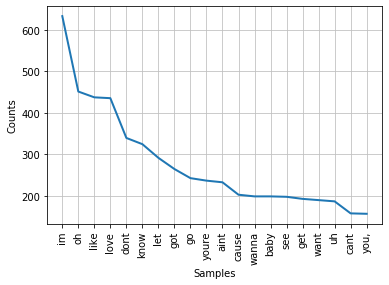

In [4]:
import nltk
from nltk.corpus import stopwords

sr= stopwords.words('english')
clean_tokens = tokens[:]
for token in tokens:
    if token in stopwords.words('english'):
        clean_tokens.remove(token)
        
freq = nltk.FreqDist(clean_tokens)
# for key,val in freq.items():
#     print(str(key) + ':' + str(val))
freq.plot(20, cumulative=False)

### Word Cloud

In [5]:
def multi_color_func(word=None, font_size=None,
                     position=None, orientation=None,
                     font_path=None, random_state=None):
    colors = [[4, 77, 82],
              [25, 74, 85],
              [82, 43, 84],
              [158, 48, 79]]
    rand = random_state.randint(0, len(colors) - 1)
    return "hsl({}, {}%, {}%)".format(colors[rand][0], colors[rand][1], colors[rand][2])

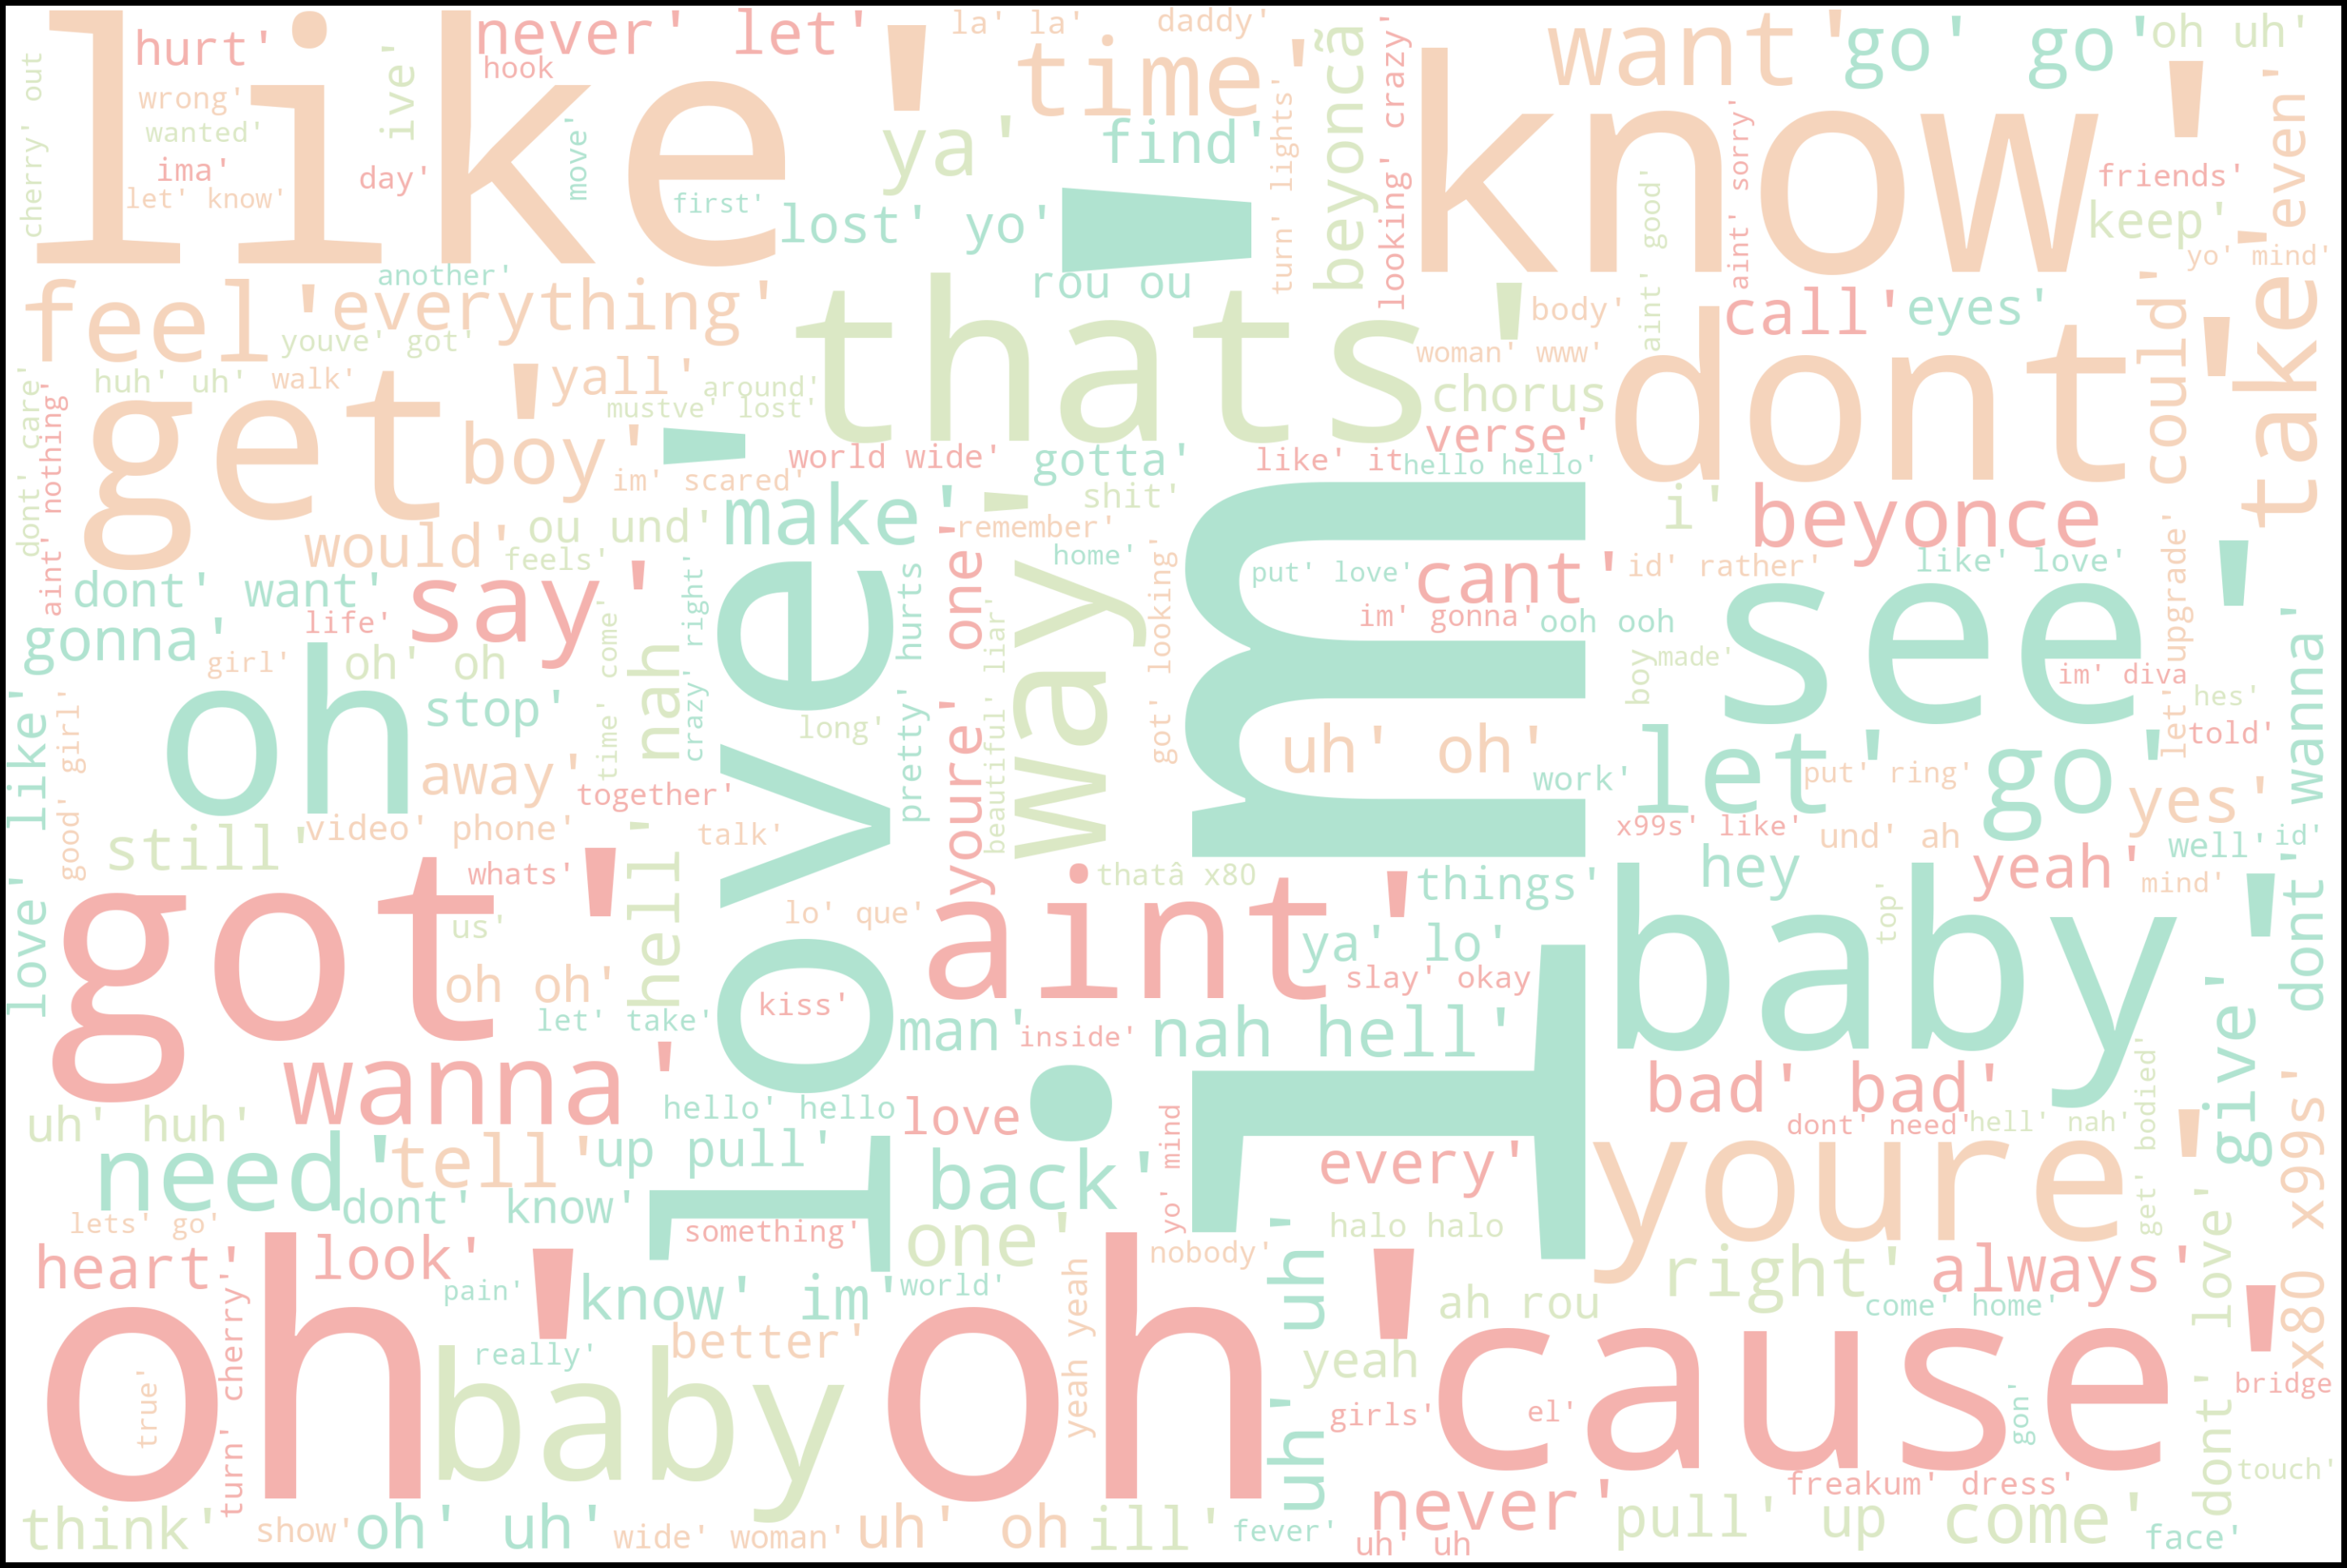

In [6]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

text = clean_tokens
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'white',
    color_func=multi_color_func,
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()


### TF-IDF

In [7]:
speech = df['Song Lyrics']
speech = speech.str.replace('[^a-zA-Z]', ' ').str.lower()
words = pd.Series(speech.str.split().sum()).value_counts()

In [8]:
tfidf = pd.DataFrame([], index=speech.index)  # dataframe of documents
tf_denom = (df['Song Lyrics'].str.count(' ') + 1)
for w in words.iloc[0:500].index:
    # imperfect pattern match for speed
    re_pat = '%s' % w
    tf = df['Song Lyrics'].str.count(re_pat) / tf_denom
    idf = np.log(len(df) / df['Song Lyrics'].str.count(re_pat).sum())
    tfidf[w] =  tf * idf
tfidf.head()

you         i       the        me        to         a        my  \
0 -0.226410 -1.349665 -0.051215 -0.039077 -0.162964 -1.417954 -0.082382   
1 -0.099229 -0.942526 -0.025899 -0.243718 -0.117729 -1.412375 -0.087949   
2 -0.395772 -0.936213 -0.022381 -0.273230 -0.071217 -0.901320 -0.048002   
3 -0.000000 -1.446605 -0.000000 -0.072292 -0.032302 -1.430845 -0.000000   
4 -0.242232 -1.375218 -0.154108 -0.052259 -0.015567 -1.580250 -0.097931   

        and        it        oh  ...  shake  radio  shouldve  finally  pero  \
0 -0.128538 -0.024215 -0.113221  ...    0.0    0.0       0.0      0.0   0.0   
1 -0.083573 -0.073473 -0.211403  ...    0.0    0.0       0.0      0.0   0.0   
2 -0.032098 -0.042329 -0.000000  ...    0.0    0.0       0.0      0.0   0.0   
3 -0.000000 -0.011200 -0.000000  ...    0.0    0.0       0.0      0.0   0.0   
4 -0.085950 -0.048577 -0.011647  ...    0.0    0.0       0.0      0.0   0.0   

   taste        se  kill  morning  miss  
0    0.0 -0.039731   0.0      0.0   0.0  
1    0.0 -0.020092   0.0      0.0   0.0  
2    0.0 -0.017363   0.0      0.0   0.0  
3    0.0 -0.073502   0.0      0.0   0.0  
4    0.0 -0.000000   0.0      0.0   0.0  

[5 rows x 500 columns]

In [9]:
# Most "important" words based on TF-idf calculation
list(tfidf.idxmax(axis=1)[:20])

['run',
 'shoot',
 'youve',
 'soy',
 'inside',
 'halo',
 'sweet',
 'www',
 'freedom',
 'home',
 'upgrade',
 'myself',
 'flawless',
 'shakira',
 'either',
 'wanted',
 'find',
 'hurts',
 'temptation',
 'looking']

# Model Creation

In [10]:
from nltk.util import pad_sequence
from nltk.util import bigrams
from nltk.util import ngrams
from nltk.util import everygrams
from nltk.lm.preprocessing import pad_both_ends
from nltk.lm.preprocessing import flatten

### Probability

In [11]:
from nltk.corpus import reuters
from nltk import bigrams, trigrams
from collections import Counter, defaultdict

# Create a placeholder for model
model = defaultdict(lambda: defaultdict(lambda: 0))

for sentence in df['Song Lyrics']:
#     print(sentence + '\n')
    sentence = sentence.split()
    for w1, w2, w3 in trigrams(sentence, pad_right=True, pad_left=True):
#         print(w1,w2,w3)
        model[(w1, w2)][w3] += 1

for w1_w2 in model:
    total_count = float(sum(model[w1_w2].values()))
    for w3 in model[w1_w2]:
        model[w1_w2][w3] /= total_count
        

### N-Gram Calculator

In [48]:
trigrams = ngrams(tokens,3)
tricount = Counter(trigrams)

trivals = tricount.values()
denom = sum(trivals)
trivals = [x for x in trivals]
phrase = [x for x in tricount.keys()]
tridf2 = pd.DataFrame({'Phrase': phrase, 'Freq': trivals})

In [49]:
quadgrams = ngrams(tokens,4)
quadcount = Counter(quadgrams)

quadvals = quadcount.values()
denom = sum(quadvals)
quadvals = [x for x in quadvals]
phrase = [x for x in quadcount.keys()]
quaddf2 = pd.DataFrame({'Phrase': phrase, 'Freq': quadvals})

Text(0, 0.5, 'Frequency')

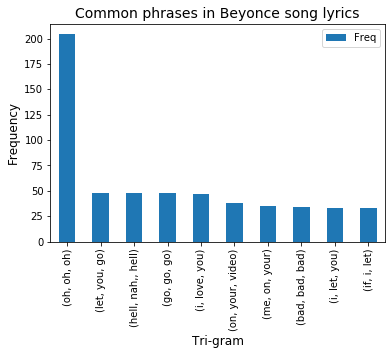

In [50]:
tridf2.sort_values(by='Freq', ascending=False)[:10].plot.bar(x = 'Phrase', y = 'Freq')
plt.title('Common phrases in Beyonce song lyrics', fontsize=14)
plt.xlabel('Tri-gram', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

Text(0, 0.5, 'Frequency')

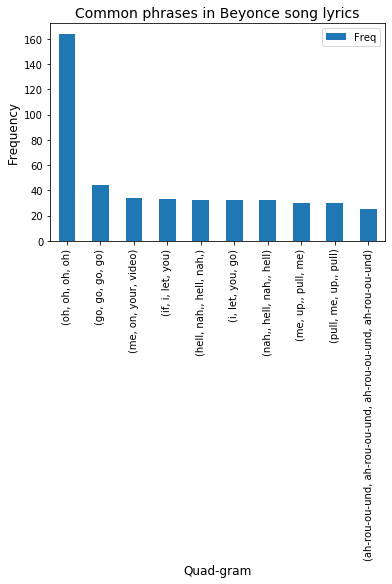

In [51]:
quaddf2.sort_values(by='Freq', ascending=False)[:10].plot.bar(x = 'Phrase', y = 'Freq')
plt.title('Common phrases in Beyonce song lyrics', fontsize=14)
plt.xlabel('Quad-gram', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

In [17]:
def ngrams_calc(lst, n):
#     lst = lst.split(' ')
    output = []
    for i in range(len(lst)-n+1):
        output.append(lst[i:i+n])
    return output

### Generated Text Analysis

In [18]:
f = open("generated_lyrics.txt", "r")
print(f.read())

In [19]:
path_to_file = ('../data/generated_lyrics.txt')

In [20]:
text = open(path_to_file, 'rb').read().decode(encoding = "ISO-8859-1")

In [21]:
pd.set_option('display.max_colwidth', -1)

df.loc[df['Song Title'] == 'drunkinlove', 'Song Lyrics']

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


76    [intro - beyoncã©] ive been drinking, ive been drinking i get filthy when that liquor get into me ive been thinking, ive been thinking why cant i keep my fingers off it, baby? i want you, na na why cant i keep my fingers off it, baby? i want you, na na  [verse 1 - beyoncã©] cigars on ice, cigars on ice feeling like an animal with these cameras all in my grill flashing lights, flashing lights you got me faded, faded, faded baby, i want you, na na cant keep your eyes off my fatty daddy, i want you, na na drunk in love, i want you  [hook - beyoncã©] we woke up in the kitchen saying, "how the hell did this shit happen?" oh baby, drunk in love we be all night last thing i remember is our beautiful bodies grinding up in the club drunk in love  [bridge - beyoncã©] we be all night, love, love we be all night, love, love  [verse 2 - beyoncã©] we be all night, and everything alright no complaints from my body, so fluorescent under these lights boy, im drinking, park it in my lot 7-11 im ru

#### 

In [22]:
text

'drunk in love we be all night  and im scared of being alone i cant sendin something to run, run, roll up rain all away, fall away" bay the badies on the floor then you mix it up and call it creole [repeat 2x]  sees ang all you breakin its the side way i dont wanna wake up fronty stape with your ears  drown into your own all cause you wont let you go ill be your friend i will love you so deeply i gue shee vost aint got no ding on that wood, graining, gramping what ill move aint shining im aside foutin all my firstend (yea) im mile) its my showe you gonng time oout a chinch like a falont the love you like cause i close my eyes but im just too big homie the  need to ke up on it, im gon let you would real good wanna house if you dont know now you took your talk that i bought you! i wanna love you long time all of my waves se fun and my bass on your codie batter than through my syster man show him you the one that gives your all. youre the one that always callsice Â©nough welkn moves amore

In [23]:
gen_tokens = text.split()

In [24]:
trigrams = ngrams(gen_tokens,3)
tricount = Counter(trigrams)

trivals = tricount.values()
denom = sum(trivals)
trivals = [x for x in trivals]
phrase = [x for x in tricount.keys()]
tridf = pd.DataFrame({'Phrase': phrase, 'Freq': trivals})

Text(0, 0.5, 'Frequency')

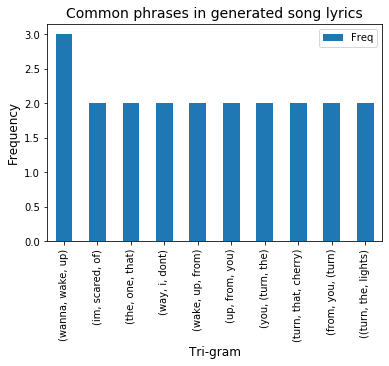

In [42]:
tridf.sort_values(by='Freq', ascending=False)[:10].plot.bar(x = 'Phrase', y = 'Freq')
plt.title('Common phrases in generated song lyrics', fontsize=14)
plt.xlabel('Tri-gram', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

In [26]:
quadgrams = ngrams(gen_tokens,4)
quadcount = Counter(quadgrams)

quadvals = quadcount.values()
denom = sum(quadvals)
quadvals = [x for x in quadvals]
phrase = [x for x in quadcount.keys()]
quaddf = pd.DataFrame({'Phrase': phrase, 'Freq': quadvals})

Text(0, 0.5, 'Frequency')

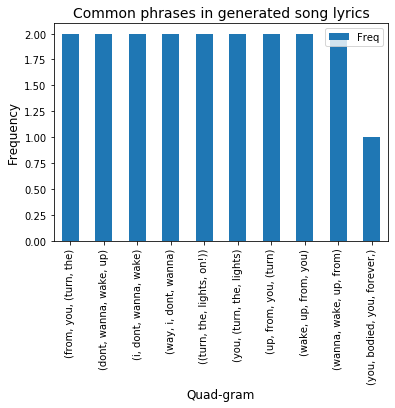

In [41]:
quaddf.sort_values(by='Freq', ascending=False)[:10].plot.bar(x = 'Phrase', y = 'Freq')
plt.title('Common phrases in generated song lyrics', fontsize=14)
plt.xlabel('Quad-gram', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

In [28]:
sr= stopwords.words('english')
clean_gen_tokens = gen_tokens[:]
for token in gen_tokens:
    if token in stopwords.words('english'):
        clean_gen_tokens.remove(token)

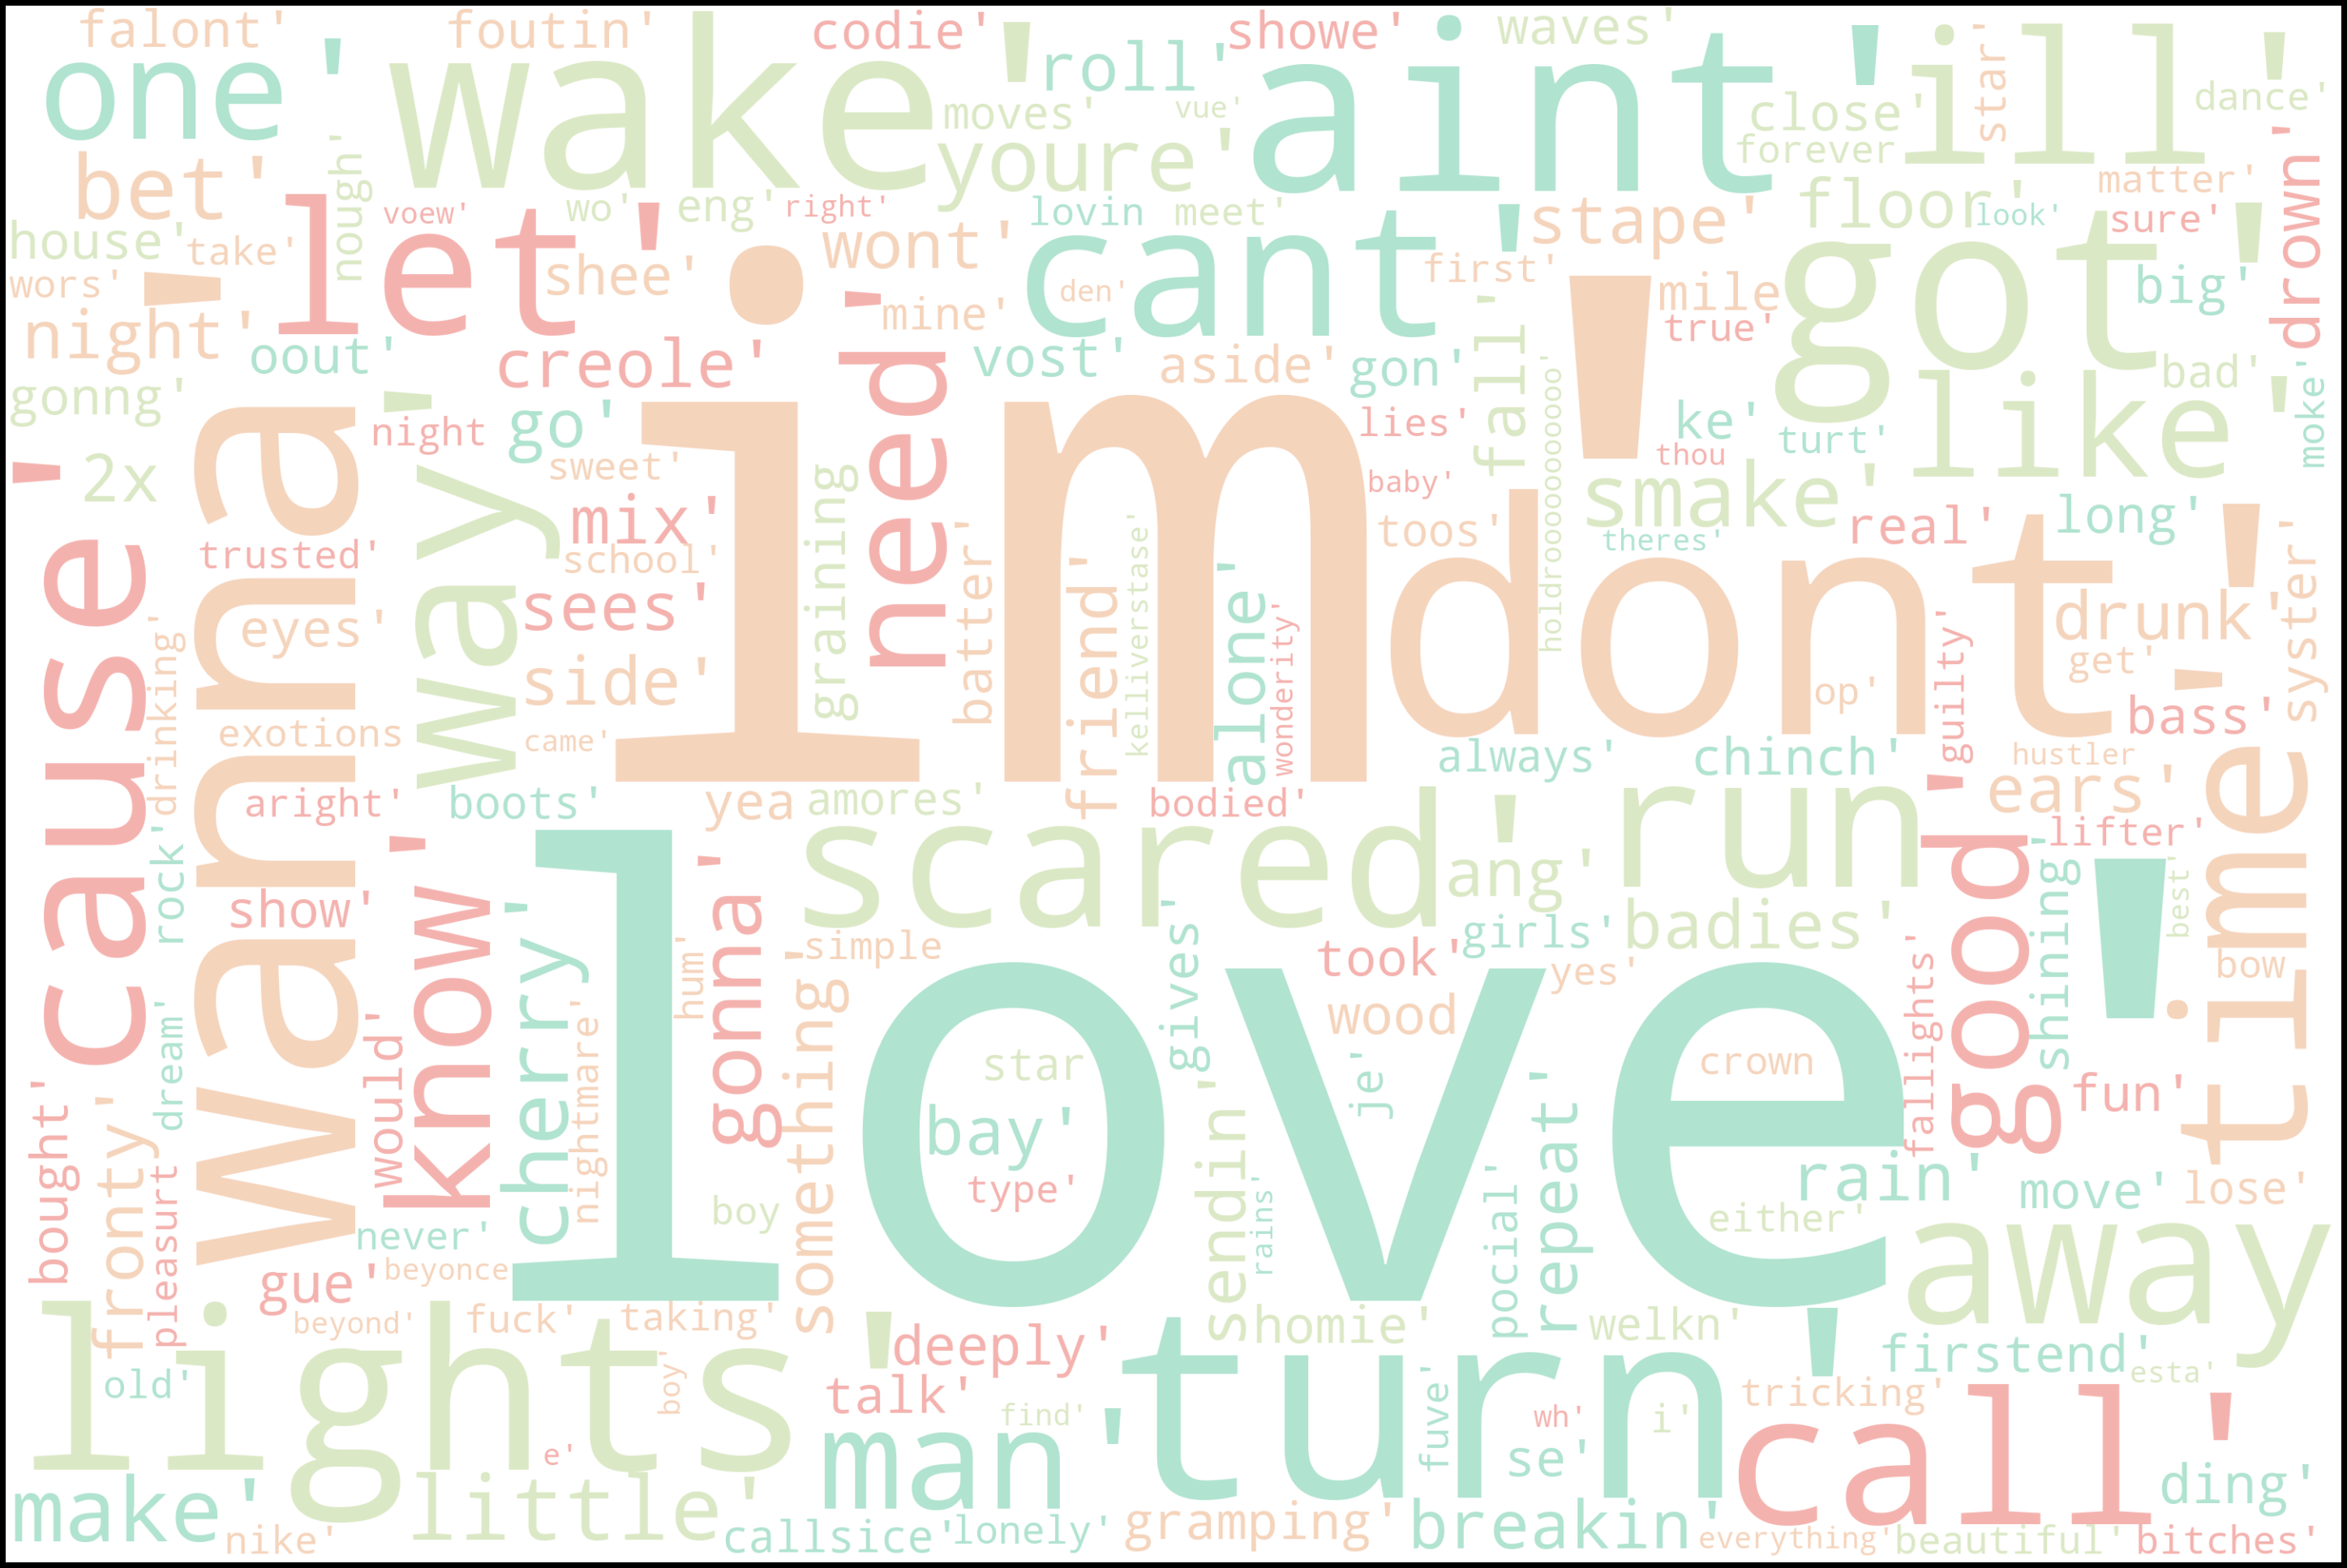

In [29]:
text = clean_gen_tokens
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'white',
    color_func=multi_color_func,
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

